In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/forest_fire_dataset/mask')
lst = os.listdir('/content/drive/MyDrive/forest_fire_dataset/mask')
print(lst)

['2_30_391.png', '2_30_4.png', '2_30_432.png', '2_30_433.png', '2_30_438.png', '2_30_439.png', '2_30_441.png', '2_30_450.png', '2_30_458.png', '2_30_456.png', '2_30_463.png', '2_30_462.png', '2_30_482.png', '2_30_487.png', '2_30_517.png', '2_30_6.png', '2_30_617.png', '2_30_618.png', '2_30_622.png', '2_30_619.png', '2_30_623.png', '2_30_624.png', '2_30_625.png', '2_30_626.png', '2_30_627.png', '2_30_628.png', '2_30_629.png', '2_30_630.png', '2_30_631.png', '2_30_632.png', '2_30_634.png', '2_30_636.png', '2_30_635.png', '2_30_637.png', '2_30_638.png', '2_30_639.png', '2_30_642.png', '2_30_645.png', '2_30_644.png', '2_30_643.png', '2_30_646.png', '2_30_647.png', '2_30_649.png', '2_30_648.png', '2_30_651.png', '2_30_652.png', '2_30_653.png', '2_30_654.png', '2_30_655.png', '2_30_657.png', '2_30_659.png', '2_30_661.png', '2_30_663.png', '2_30_664.png', '2_30_665.png', '2_30_667.png', '2_30_670.png', '2_30_671.png', '2_30_674.png', '2_30_679.png', '2_30_680.png', '2_30_681.png', '2_30_682.p

In [ ]:
mask = []
img = []
for filename in lst:
    if filename.endswith('.png'):
        img.append(filename)
        mask.append(filename)

In [ ]:
len(img)

3076

In [ ]:
y = np.zeros((3076, 224, 224), dtype=np.float32)
X = np.zeros((3076, 224, 224, 1), dtype=np.float32)

In [ ]:
for i in img:
    index = img.index(i)
    dir_img = os.path.join('/content/drive/MyDrive/forest_fire_dataset/og', i)
    im = Image.open(dir_img)
    im = im.resize((224, 224))
    im = np.reshape(im.convert('L'), (224,224,1))
    X[index] = im
    m = mask[index]
    dir_mask = os.path.join('/content/drive/MyDrive/forest_fire_dataset/mask', m)
    mask_img = cv2.imread(dir_mask)
    #mask_img = (mask_img!=2)*1.0
    mask_img = cv2.resize(mask_img, (224, 224))
    mask_img = 1.0*(mask_img[:,:,0]>0.2)
    y[index] = mask_img

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-x3yr26tc
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-x3yr26tc
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 4.2 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=845890d5ad3772655d69a6a0b8b04cbe2436ce5b3e34cba083ea9ac2e75e6f24
  Stored in directory: /tmp/pip-ephem-wheel-cache-694stz_s/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import Input, Conv2D, Reshape, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

Segmentation Models: using `keras` framework.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [ ]:
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers import Reshape
N = X_train.shape[-1]

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
inputs = layers.Input(shape=(224, 224, 1))
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
model = Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.0001),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%time history = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
77/77 [==============================] - 80s 753ms/step - loss: 0.1466 - binary_crossentropy: 0.6194 - dice_coef: 0.1631 - val_loss: 0.1528 - val_binary_crossentropy: 0.5512 - val_dice_coef: 0.1253
Epoch 2/100
77/77 [==============================] - 51s 658ms/step - loss: -0.0090 - binary_crossentropy: 0.3723 - dice_coef: 0.1952 - val_loss: 0.1050 - val_binary_crossentropy: 0.4606 - val_dice_coef: 0.1268
Epoch 3/100
77/77 [==============================] - 51s 662ms/step - loss: -0.0499 - binary_crossentropy: 0.3321 - dice_coef: 0.2160 - val_loss: 0.0165 - val_binary_crossentropy: 0.3823 - val_dice_coef: 0.1754
Epoch 4/100
77/77 [==============================] - 51s 661ms/step - loss: -0.0934 - binary_crossentropy: 0.3040 - dice_coef: 0.2454 - val_loss: -0.0463 - val_binary_crossentropy: 0.3309 - val_dice_coef: 0.2121
Epoch 5/100
77/77 [==============================] - 51s 660ms/step - loss: -0.1238 - binary_crossentropy: 0.2951 - dice_coef: 0.2715 - val_loss: 0.0391 - v

In [ ]:
%time model.evaluate(X_test, y_test)

20/20 [==============================] - 4s 181ms/step - loss: -0.5923 - binary_crossentropy: 0.1833 - dice_coef: 0.6893
CPU times: user 922 ms, sys: 217 ms, total: 1.14 s
Wall time: 5.65 s


[-0.5922809839248657, 0.18329736590385437, 0.6892573237419128]

In [ ]:
train_loss = history.history['loss']
train_bc = history.history['binary_crossentropy']
train_dice = history.history['dice_coef']
val_loss = history.history['val_loss']
val_bc = history.history['val_binary_crossentropy']
val_dice = history.history['val_dice_coef']
print('Average training loss: ', np.mean(train_loss))
print('Average training binary crossentropy: ', np.mean(train_bc))
print('Average training dice score: ', np.mean(train_dice))
print('Average validation loss: ', np.mean(val_loss))
print('Average validation binary crossentropy: ', np.mean(val_bc))
print('Average validation dice score: ', np.mean(val_dice))

Average training loss:  -0.7245694756507873
Average training binary crossentropy:  0.09330823056399823
Average training dice score:  0.77119818598032
Average validation loss:  -0.48466029509902
Average validation binary crossentropy:  0.21580468386411666
Average validation dice score:  0.5936705955862999


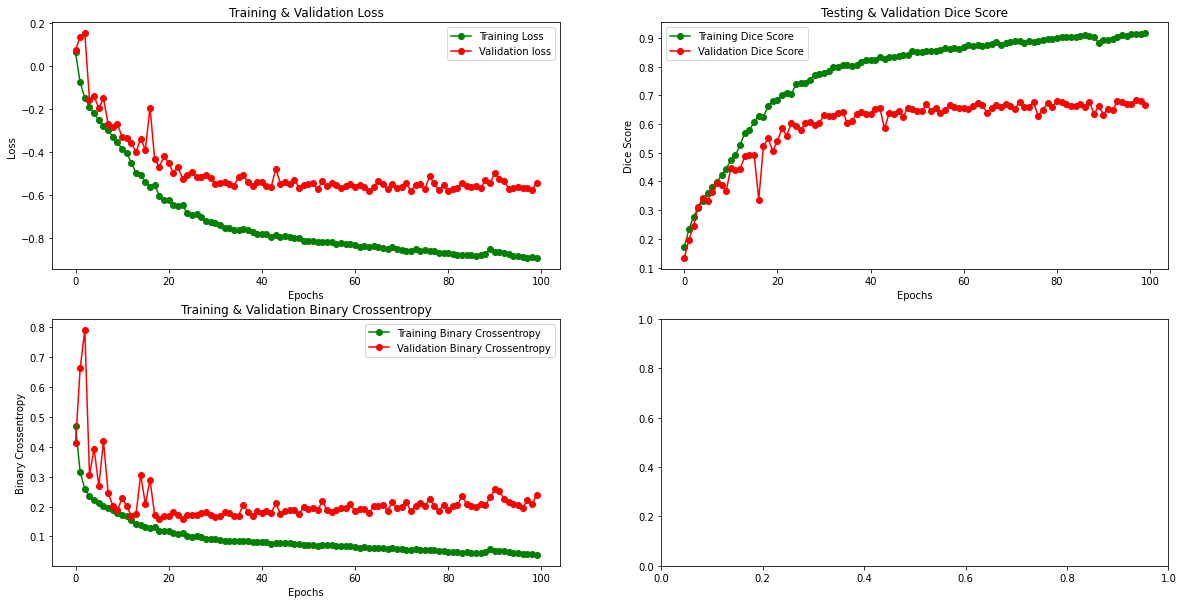

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,10)

ax[0][0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0][0].plot(epochs , val_loss , 'ro-' , label = 'Validation loss')
ax[0][0].set_title('Training & Validation Loss')
ax[0][0].legend()
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Loss")

ax[1][0].plot(epochs , train_bc , 'go-' , label = 'Training Binary Crossentropy')
ax[1][0].plot(epochs , val_bc , 'ro-' , label = 'Validation Binary Crossentropy')
ax[1][0].set_title('Training & Validation Binary Crossentropy')
ax[1][0].legend()
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Binary Crossentropy")

ax[0][1].plot(epochs , train_dice , 'g-o' , label = 'Training Dice Score')
ax[0][1].plot(epochs , val_dice , 'r-o' , label = 'Validation Dice Score')
ax[0][1].set_title('Testing & Validation Dice Score')
ax[0][1].legend()
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Dice Score")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/forest_fire_dataset/segnet.h5')

In [ ]:
training_pred = model.predict(X_train)
testing_pred = model.predict(X_test)

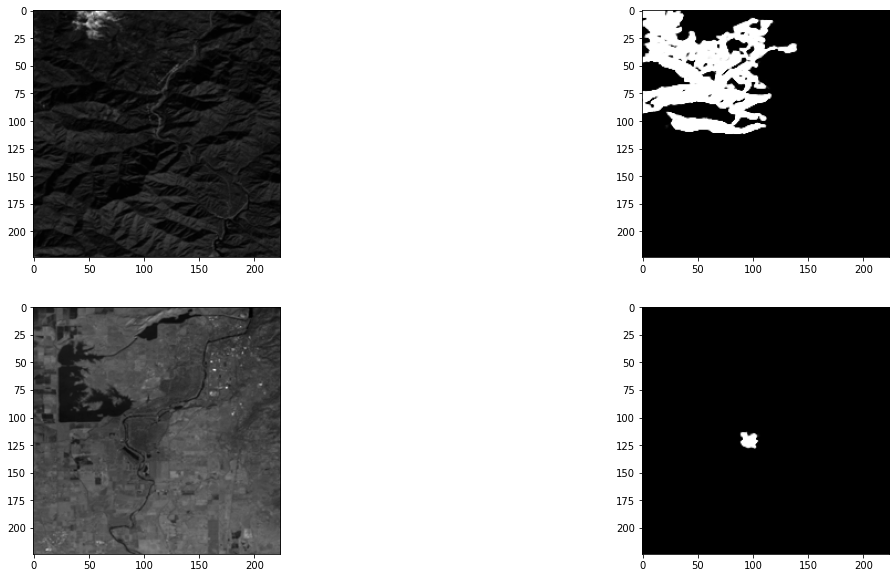

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
k = 3
scale = 255
fig.add_subplot(2, 2, 1)
plt.imshow(np.squeeze(X_train[k]), cmap='gray')
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(2, 2, 3)
plt.imshow(np.squeeze(X_train[k+1]), cmap='gray')
fig.add_subplot(2, 2, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')

0


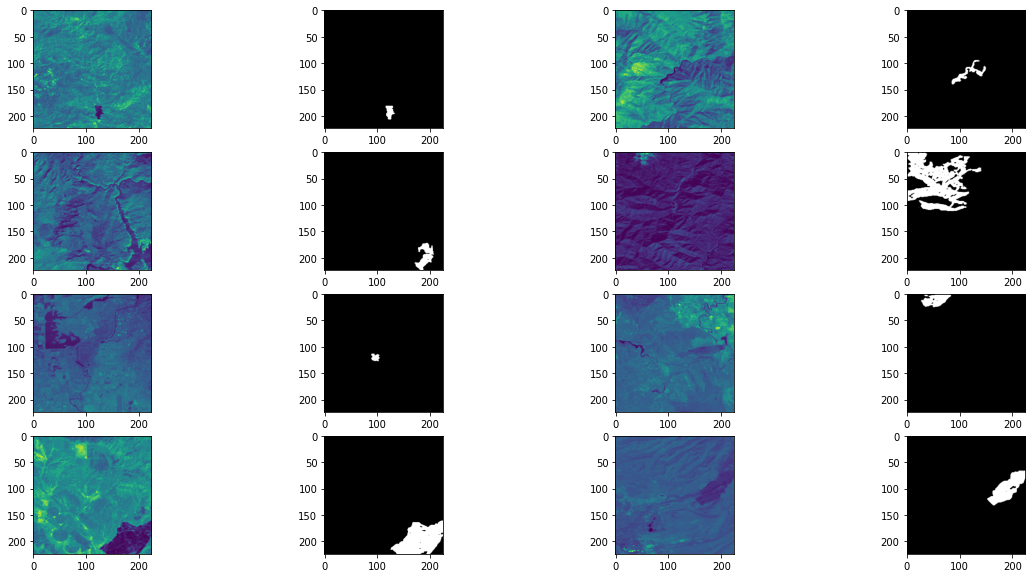

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
#k = random.randint(0, 3000)
k = 0
print(k)
scale = 255
fig.add_subplot(4, 4, 1)
plt.imshow(np.squeeze(X_train[k]))
fig.add_subplot(4, 4, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(4, 4, 3)
plt.imshow(np.squeeze(X_train[k+1]))
fig.add_subplot(4, 4, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')
fig.add_subplot(4, 4, 5)
plt.imshow(np.squeeze(X_train[k+2]))
fig.add_subplot(4, 4, 6)
plt.imshow(np.squeeze(training_pred[k+2] * scale), cmap='gray')
fig.add_subplot(4, 4, 7)
plt.imshow(np.squeeze(X_train[k+3]))
fig.add_subplot(4, 4, 8)
plt.imshow(np.squeeze(training_pred[k+3] * scale), cmap='gray')
fig.add_subplot(4, 4, 9)
plt.imshow(np.squeeze(X_train[k+4]))
fig.add_subplot(4, 4, 10)
plt.imshow(np.squeeze(training_pred[k+4] * scale), cmap='gray')
fig.add_subplot(4, 4, 11)
plt.imshow(np.squeeze(X_train[k+5]))
fig.add_subplot(4, 4, 12)
plt.imshow(np.squeeze(training_pred[k+5] * scale), cmap='gray')
fig.add_subplot(4, 4, 13)
plt.imshow(np.squeeze(X_train[k+6]))
fig.add_subplot(4, 4, 14)
plt.imshow(np.squeeze(training_pred[k+6] * scale), cmap='gray')
fig.add_subplot(4, 4, 15)
plt.imshow(np.squeeze(X_train[k+7]))
fig.add_subplot(4, 4, 16)
plt.imshow(np.squeeze(training_pred[k+7] * scale), cmap='gray')

0


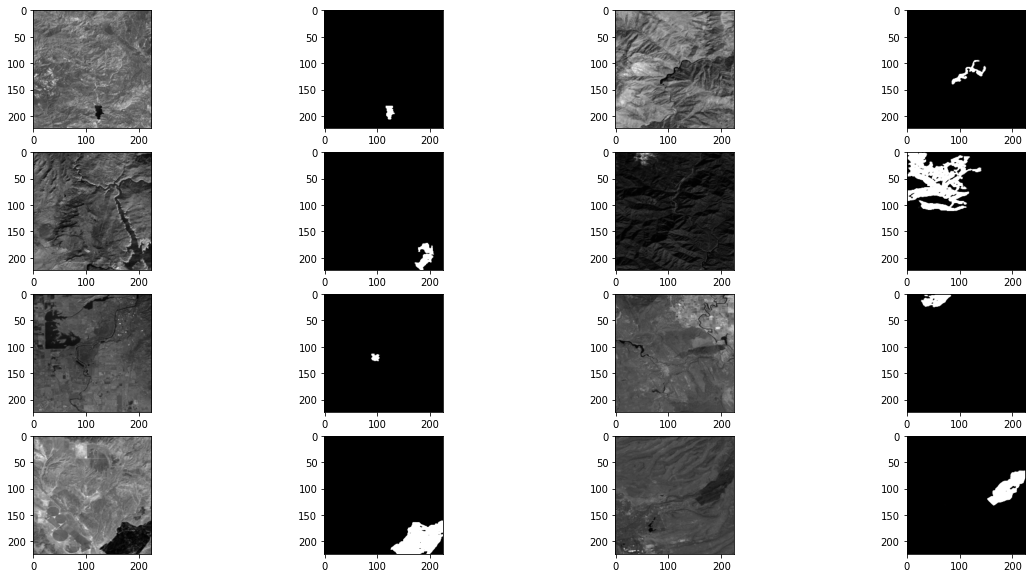

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
#k = random.randint(0, 3000)
k = 0
print(k)
scale = 255
fig.add_subplot(4, 4, 1)
plt.imshow(np.squeeze(X_train[k]), cmap='gray')
fig.add_subplot(4, 4, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(4, 4, 3)
plt.imshow(np.squeeze(X_train[k+1]), cmap='gray')
fig.add_subplot(4, 4, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')
fig.add_subplot(4, 4, 5)
plt.imshow(np.squeeze(X_train[k+2]), cmap='gray')
fig.add_subplot(4, 4, 6)
plt.imshow(np.squeeze(training_pred[k+2] * scale), cmap='gray')
fig.add_subplot(4, 4, 7)
plt.imshow(np.squeeze(X_train[k+3]), cmap='gray')
fig.add_subplot(4, 4, 8)
plt.imshow(np.squeeze(training_pred[k+3] * scale), cmap='gray')
fig.add_subplot(4, 4, 9)
plt.imshow(np.squeeze(X_train[k+4]), cmap='gray')
fig.add_subplot(4, 4, 10)
plt.imshow(np.squeeze(training_pred[k+4] * scale), cmap='gray')
fig.add_subplot(4, 4, 11)
plt.imshow(np.squeeze(X_train[k+5]), cmap='gray')
fig.add_subplot(4, 4, 12)
plt.imshow(np.squeeze(training_pred[k+5] * scale), cmap='gray')
fig.add_subplot(4, 4, 13)
plt.imshow(np.squeeze(X_train[k+6]), cmap='gray')
fig.add_subplot(4, 4, 14)
plt.imshow(np.squeeze(training_pred[k+6] * scale), cmap='gray')
fig.add_subplot(4, 4, 15)
plt.imshow(np.squeeze(X_train[k+7]), cmap='gray')
fig.add_subplot(4, 4, 16)
plt.imshow(np.squeeze(training_pred[k+7] * scale), cmap='gray')